In [ ]:
# Goal: Analyze data on patients with diabetes to see how successful models are at predicting
# hospital readmission within 30 days
#
# Models created:
#   Logistic regression
#   Random Forest Classifier
#   Multilayer Perceptron
#   Boosting
#   K-Nearest Neighbors Classifier
#
# Note: Didn't do SVM because data had tons of rows and not that many predictors, which isn't
# the best choice for SVM
# 
# Hyperparameter Tuning using bayesian inference with scikit-optimize's BayesSearchCV
#
# Predictors include:
#   time in hospital
#   number of lab procedures, other procedures, and medications given
#   number of diagnoses
#   number of outpatient, emergency, and inpatient visits in the past year
#   demographics: age, race, sex
#   status at discharge (e.g., discharged to same/higher level of care, or discharged home/lower level of care, or left against medical advice)
#   admission type (emergency, urgent, elective, etc)
#   if there was a change in diabetic medications (change, no change)
#   if diabetic medication was prescribed (Y/N)
#   labs
#
# Data Source: https://archive.ics.uci.edu/dataset/296/diabetes+130-us+hospitals+for+years+1999-2008
#
# Part 1: Data Cleaning, Preparation, Exploration
# Date last updated: 1/19/2024
# Author: Kay Rubio

In [145]:
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from skopt import BayesSearchCV
import time
# ignore future warnings that aren't necessary for this project
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


In [55]:
# import data built during data preparation (see separate notebook)
x_train = pd.read_csv("./x_train.csv")
y_train = pd.read_csv("./y_train.csv")
x_test = pd.read_csv("./x_test.csv")
y_test = pd.read_csv("./y_test.csv")
x_train_reduced = pd.read_csv("./x_train_reduced.csv")
x_test_reduced = pd.read_csv("./x_test_reduced.csv")

In [56]:
# drop the ID columns from the datasets
x_train.drop('Unnamed: 0', axis=1, inplace=True) 
y_train.drop('Unnamed: 0', axis=1, inplace=True) 
x_test.drop('Unnamed: 0', axis=1, inplace=True) 
y_test.drop('Unnamed: 0', axis=1, inplace=True) 
x_train_reduced.drop('Unnamed: 0', axis=1, inplace=True) 
x_test_reduced.drop('Unnamed: 0', axis=1, inplace=True)

In [57]:
y_train.head()

,readmitted2
0,0
1,0
2,1
3,0
4,0


In [58]:
y_train_array = y_train['readmitted2'].to_numpy().tolist();
y_test_array = y_test['readmitted2'].to_numpy().tolist();
# print(y_train_array)

In [ ]:
# Model #1a: Logistic Regression without hyperparameter tuning or cross-validation
# Although the data isn't perfect for this (some continuous variables are not normally distributed, 
# there are issues with outliers, and imbalanced categories, lets start with this as a baseline model
# on the reduced dataset

In [99]:
# Learn some information about the model
# print(help(LogisticRegression))
# dir(LogisticRegression)

In [59]:
lr = LogisticRegression(max_iter=1000).fit(x_train_reduced, y_train_array)
y_pred_lr = lr.predict(x_test_reduced) # get the predicted y-values

In [63]:
print('In the true data, ' + str(y_test_array.count(1)) + ' were readmitted, while ' + str(y_test_array.count(0)) + ' were not')

In the true data, 2812 were readmitted, while 22177 were not


In [65]:
print('The model predicted that, ' + str(y_pred_lr.tolist().count(1)) + ' were readmitted, while ' + str(y_pred_lr.tolist().count(0)) + ' were not')

The model predicted that, 84 were readmitted, while 24905 were not


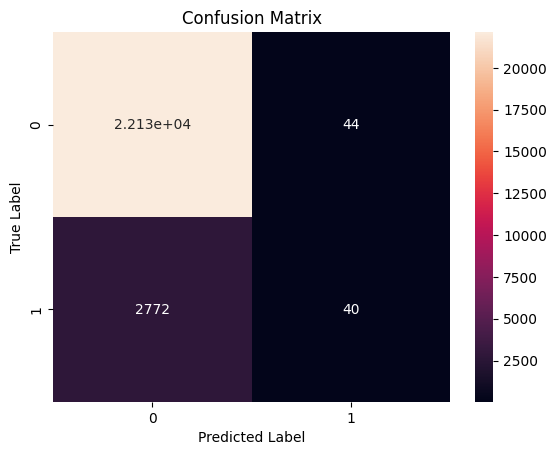

In [90]:
def confusionMatrix(y_pred):
    cmat = confusion_matrix(y_test_array, y_pred)
    ax = plt.axes()
    sns.heatmap(cmat, ax = ax,annot=True , fmt = '.4g')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()
confusionMatrix(y_pred_lr)

In [ ]:
# True negatives (pts who were NOT readmitted in 30 days): 22133
# True positives (pts who were readmitted in 30 days): 40
# False negatives (pts predicted to NOT be readmitted but who did get readmitted in 30 days): 2772
# False positives (pts predicted to be readmitted who did NOT get readmitted in 30 days): 44
#
# If the goal is to identify people at risk of readmission and give them more support to help prevent 
# readmission, you probably want to err on the side of caution, with higher false positive rate than 
# false negative rate. However, this model has a lot more error in false negatives - these are pts who 
# did get readmitted but model didn’t predict that. 

In [93]:
def describeModelResults(Mdl, y_pred):
    accuracy = round(accuracy_score(y_test_array, y_pred)*100, 3)
    precision = round(precision_score(y_test_array, y_pred)*100, 3)
    recall = round(recall_score(y_test_array, y_pred)*100, 3)
    print('{} found accuracy: {}%, precision: {}%, recall: {}%'.format(Mdl, accuracy, precision, recall));

describeModelResults('Logistic Regression', y_pred_lr)

Logistic Regression found accuracy: 88.731%, precision: 47.619%, recall: 1.422%


In [75]:
# Accuracy = number predicted correctly / total number of examples
#   88% accuracy sounds good, but not when you see that in the real data 88% percent were not readmitted
#   so if the model had just predicted that no one was readmitted, it would have been 88% accurate. 
#   The model was more nuanced than this, and did predict that some people were readmitted, but not well.
#
# Precision in binary outcome = 
#	precision: true positives / number of results the model predicted as positive
#	if false positives are really bad - optimize model for precision
#	48% precision - when the model identified readmission, 47% were readmitted
#
# Recall in binary outcome = 
#	recall: true positives / number of positive results in test data(regardless of models predictions) 
#	if false negatives are really bad- optimize models for recall
#	1% recall means that model only predicted 1% of people who were readmitted as going to be readmitted
# 
# In this example, I'd probably want to minimize false negatives, so I want to see good recall.  But 
# this model's recall was pretty bad - missed a lot of people at risk of readmission.
# Some improvements could be made by transforming predictors for more normal distributions, checking outliers,
# but the biggest problem is probably that the outcome is very imbalanced, and logistic regression tends to 
# favors the majority category in its predictions

In [97]:
# Get the coefficients for each predictor and intercept
coefficients = lr.coef_
intercept = lr.intercept_

# Display the coefficients for each feature - higher values indicate stronger relationships
for feature, coef in zip(x_train_reduced.columns, coefficients[0]):
    print(f"{feature}: {coef}")

# Display the intercept
print(f"Intercept: {intercept}")

time_in_hospital: 0.015037628374623888
num_lab_procedures: 0.0004339659635814846
num_procedures: -0.01516361367952726
num_medications: 0.005745663001898413
number_outpatient: -0.005218927181843364
number_emergency: 0.03594259105397109
number_inpatient: 0.2684397727417498
number_diagnoses: 0.036263292642722524
age2: 0.001624062888053533
discharge_disposition_id2: 0.43418954989377084
admission_type_id2: -0.01213764363979884
metformin2: -0.06997333816873916
repaglinide2: 0.031829485707096226
pioglitazone2: -0.0472653604576062
insulin2: -0.018356372071118607
change2: 0.034950198622645284
diabetesMed2: 0.19861216779780977
Intercept: [-3.03940826]


In [ ]:
# To summarize some of the above, the 3 strongest predictors and the direction of relationships:
#   discharge disposition, discharged to a higher level of care (coded as 1) was more likely to be readmitted within 30 days
#   number of inpatient visits in past year, where the higher the number of visits, the more likely to be readmitted in 30 days
#   diabetes med - if there was a change (coded as 1) they were more likely to be readmitted within 30 days
# 
# Note: if I were to further tune the model, I could cut out those with weaker relationships.  Since this package doesn't
#    provide p-values for individual predictors, I can't assess which predictors were significant in the model, but I could 
#    try other statistical packages that provide more details

In [86]:
# Model #1b: Logistic Regression WITH hyperparameter tuning and 3-fold cross-validation
#
# use BayesSearchCV to wrap the model, giving it different hyperparameters to try out
# in logistic regression, try different C values, a regularization parameter that helps with over/under fitting
# default is 1
# Also setting cv to 3, which means in cross fold validation, the data will be divided into 3 parts, 2 parts 
# to be used as train data, and 1 part for test, then it will rotate to use the other 2 parts as train and the third
# as test. Helps reduce over fitting. 
lr2 = BayesSearchCV(
    LogisticRegression(),
    {
        'C': (0.001, 0.01, 0.1, 1, 10, 100, 1000),
        # 'C': (1e-6, 1e+6, 'log-uniform), # another option for hyperparameter tuning
        'max_iter': (1000)
    },
    n_iter=32,
    cv=3
)

# fit the model to the data
np.int = int # seems to be some error related to skopt using np.int but np.int is deprecated in newer versions of numpy
try:
    lr2.fit(x_train_reduced, y_train_array)
except Exception as e:
    print("Error:", e)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


In [88]:
y_pred_lr_2 = lr2.predict(x_test_reduced) # get the predicted y-values

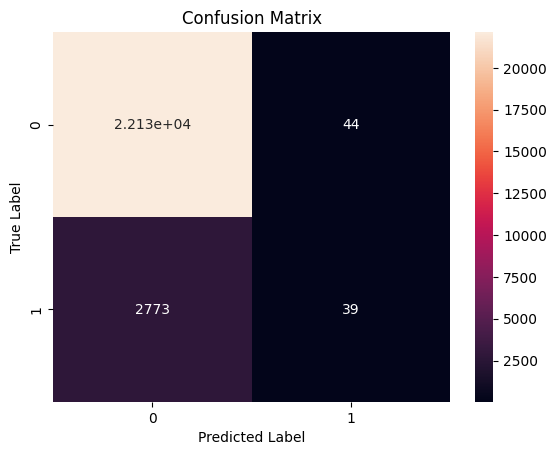

In [94]:
confusionMatrix(y_pred_lr_2)

In [95]:
describeModelResults('Logistic Regression with hyperparameter tuning', y_pred_lr_2)

Logistic Regression with hyperparameter tuning found accuracy: 88.727%, precision: 46.988%, recall: 1.387%


In [ ]:
# With hyperparameter tuning and CV, the model was slightly less accurate, slightly worse precision, and
# slightly worse recall than the original logistic regression model. Ouch. Lets try some other models

In [ ]:
# Model #2: Random Forest Classifier
# print some info about the model
# print(help(RandomForestClassifier))

In [102]:
# took less than 5 min to run on my laptop
# will try it on the reduced training data with only predictors with some correlation to outcome for now
#
# use BayesSearchCV to wrap the model, giving it different hyperparameters to try out
# in random forest, try different number of estimators (number of trees) and different
# max depths of those trees 
#
# Also setting cv to 3, which means in cross fold validation, the data will be divided into 3 parts, 2 parts 
# to be used as train data, and 1 part for test, then it will rotate to use the other 2 parts as train and the third
# as test. Helps reduce over fitting. 
rf = BayesSearchCV(
    RandomForestClassifier(),
    {
        'n_estimators': (5, 50, 100),
        'max_depth': (2, 10, 20, None)
    },
    n_iter=32,
    cv=3
)

# fit the model to the data
np.int = int # some error related to skopt using np.int but np.int is deprecated in newer versions of numpy
rf.fit(x_train_reduced, y_train_array)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-pac

BayesSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=32,
              search_spaces={'max_depth': (2, 10, 20, None),
                             'n_estimators': (5, 50, 100)})

In [103]:
# What were the best parameters it found?
print(rf.best_params_)

OrderedDict([('max_depth', 10), ('n_estimators', 50)])


In [106]:
# Check results of all hyperparameter combos that BayesSearchCV checked
means = rf.cv_results_['mean_test_score']
stds = rf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, rf.cv_results_['params']):
	print('{} (+/-{}) for {}'.format(round(mean, 3), round(std * 2, 3), params))

0.886 (+/-0.0) for OrderedDict([('max_depth', 2), ('n_estimators', 5)])
0.886 (+/-0.0) for OrderedDict([('max_depth', 10), ('n_estimators', 50)])
0.886 (+/-0.0) for OrderedDict([('max_depth', 10), ('n_estimators', 50)])
0.886 (+/-0.0) for OrderedDict([('max_depth', 10), ('n_estimators', 50)])
0.886 (+/-0.0) for OrderedDict([('max_depth', 10), ('n_estimators', 50)])
0.886 (+/-0.0) for OrderedDict([('max_depth', 10), ('n_estimators', 50)])
0.886 (+/-0.0) for OrderedDict([('max_depth', 10), ('n_estimators', 50)])
0.886 (+/-0.0) for OrderedDict([('max_depth', 10), ('n_estimators', 100)])
0.886 (+/-0.0) for OrderedDict([('max_depth', 10), ('n_estimators', 50)])
0.886 (+/-0.0) for OrderedDict([('max_depth', 20), ('n_estimators', 50)])
0.865 (+/-0.001) for OrderedDict([('max_depth', None), ('n_estimators', 5)])
0.886 (+/-0.0) for OrderedDict([('max_depth', 2), ('n_estimators', 50)])
0.886 (+/-0.001) for OrderedDict([('max_depth', 20), ('n_estimators', 50)])
0.886 (+/-0.0) for OrderedDict([('m

In [ ]:
# These all look really similar, but max-depth: 10, and n_estimators: 50 was the best

In [107]:
# Check this on the full dataset, without trimming predictors that didn't have
# much linear relationship with the outcome, and see if it's any better
rf2 = BayesSearchCV(
    RandomForestClassifier(),
    {
        'n_estimators': (5, 50, 100),
        'max_depth': (2, 10, 20, None)
    },
    n_iter=32,
    cv=3
)

# fit the model to the data
np.int = int # some error related to skopt using np.int but np.int is deprecated in newer versions of numpy
rf2.fit(x_train, y_train_array)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-pac

BayesSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=32,
              search_spaces={'max_depth': (2, 10, 20, None),
                             'n_estimators': (5, 50, 100)})

In [109]:
# What were the best parameters it found?
print(rf2.best_params_)

OrderedDict([('max_depth', 20), ('n_estimators', 100)])


In [ ]:
# using the full set of predictors, the best model had more trees and deeper depths

In [110]:
# Check results of all hyperparameter combos that BayesSearchCV checked
means = rf2.cv_results_['mean_test_score']
stds = rf2.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, rf2.cv_results_['params']):
	print('{} (+/-{}) for {}'.format(round(mean, 3), round(std * 2, 3), params))

0.886 (+/-0.0) for OrderedDict([('max_depth', 10), ('n_estimators', 5)])
0.886 (+/-0.0) for OrderedDict([('max_depth', 20), ('n_estimators', 50)])
0.886 (+/-0.0) for OrderedDict([('max_depth', 10), ('n_estimators', 100)])
0.886 (+/-0.0) for OrderedDict([('max_depth', None), ('n_estimators', 100)])
0.886 (+/-0.0) for OrderedDict([('max_depth', None), ('n_estimators', 50)])
0.886 (+/-0.0) for OrderedDict([('max_depth', 10), ('n_estimators', 50)])
0.886 (+/-0.0) for OrderedDict([('max_depth', 10), ('n_estimators', 50)])
0.886 (+/-0.0) for OrderedDict([('max_depth', 10), ('n_estimators', 5)])
0.886 (+/-0.0) for OrderedDict([('max_depth', None), ('n_estimators', 100)])
0.886 (+/-0.0) for OrderedDict([('max_depth', 10), ('n_estimators', 100)])
0.886 (+/-0.0) for OrderedDict([('max_depth', 20), ('n_estimators', 100)])
0.886 (+/-0.0) for OrderedDict([('max_depth', 10), ('n_estimators', 50)])
0.886 (+/-0.0) for OrderedDict([('max_depth', 2), ('n_estimators', 50)])
0.886 (+/-0.0) for OrderedDict

In [ ]:
# above, this accuracy of 0.886 doesn't look different from using the reduced 
# predictors dataset.  So lets stick with reduced predictors which was just as 
# successful with a slightly less complex model. 

In [113]:
# Train a model using best hyperparameters and dataset shown above.
# check it against test data
rf3 = RandomForestClassifier(max_depth=10, n_estimators=50)
rf3.fit(x_train_reduced, y_train_array)

y_pred_rf = rf3.predict(x_test_reduced) # get the predicted y-values
print('In the true data, ' + str(y_test_array.count(1)) + ' were readmitted, while ' + str(y_test_array.count(0)) + ' were not')

print('The model predicted that, ' + str(y_pred_rf.tolist().count(1)) + ' were readmitted, while ' + str(y_pred_rf.tolist().count(0)) + ' were not')

In the true data, 2812 were readmitted, while 22177 were not
The model predicted that, 27 were readmitted, while 24962 were not


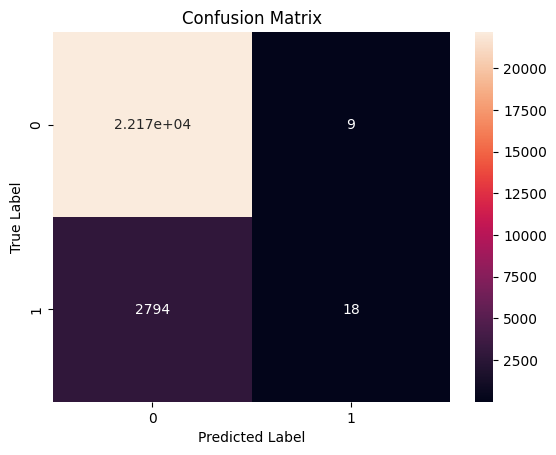

RandomForestClassifier found accuracy: 88.783%, precision: 66.667%, recall: 0.64%


In [114]:
# This isn't looking too good, model predicts that almost no one is readmitted, so 
# that's not going to help identify people at risk for readmission.  Lets make a confusion
# matrix to see the misclassifications

confusionMatrix(y_pred_rf)
describeModelResults('RandomForestClassifier', y_pred_rf)

In [ ]:
# Overall, this model performed similar to logistical regression

In [128]:
# Lets assume someone with more medical experience than me says they want to see 90% of the
# people who will be readmitted correctly identified by the model as "at risk"
# I'll update the threshold and try the predictions again

thresholds = [0.01, 0.05, 0.07, 0.1, 0.15, 0.2]

print('In the true data, ' + str(y_test_array.count(1)) + ' were readmitted, while ' + str(y_test_array.count(0)) + ' were not')
for value in thresholds:
    threshold = value
    y_pred_proba = rf3.predict_proba(x_test_reduced)[:, 1]
    y_pred = (y_pred_proba > threshold).astype(int)
    accuracy = round(accuracy_score(y_test_array, y_pred)*100, 3)
    precision = round(precision_score(y_test_array, y_pred)*100, 3)
    recall = round(recall_score(y_test_array, y_pred)*100, 3)
    # print('predicted readmitted: ' + str(y_pred.tolist().count(1)) + ', predicted not readmitted: ' + print(str(y_pred_rf_2.tolist().count(0))
    print('threshold: {}, predicted readmitted: {}, predicted not readmitted: {}, accuracy: {}%, precision: {}%, recall: {}%'.format(threshold, y_pred.tolist().count(1), y_pred_rf_2.tolist().count(0), accuracy, precision, recall));


In the true data, 2812 were readmitted, while 22177 were not
threshold: 0.01, predicted readmitted: 24989, predicted not readmitted: 19558, accuracy: 11.253%, precision: 11.253%, recall: 100.0%
threshold: 0.05, predicted readmitted: 24129, predicted not readmitted: 19558, accuracy: 14.414%, precision: 11.509%, recall: 98.755%
threshold: 0.07, predicted readmitted: 19882, predicted not readmitted: 19558, accuracy: 29.737%, precision: 12.916%, recall: 91.323%
threshold: 0.1, predicted readmitted: 11703, predicted not readmitted: 19558, accuracy: 56.945%, precision: 16.047%, recall: 66.785%
threshold: 0.15, predicted readmitted: 5431, predicted not readmitted: 19558, accuracy: 75.865%, precision: 20.365%, recall: 39.331%
threshold: 0.2, predicted readmitted: 1641, predicted not readmitted: 19558, accuracy: 85.726%, precision: 26.996%, recall: 15.754%


In [ ]:
# This shows that you can tune the model to increase recall, but at a huge loss of precision
# Let's say 99% of pts who will be re-hosp are correctly identified by the model as "at risk".
# That sounds impressive, but that model is now predicting that over half of all patients are "at risk", 
# when in reality, only a small portion of them actually going to be re-hosp

In [ ]:
# Model #3: Gradient Boosting Classifier - Megatree
# print some info about the model
# print(help(GradientBoostingClassifier))

In [116]:
# Since this one will likely take a lot longer to train because the trees have to be built
# sequentially, and other models have not been helped by the predictors that don't show any
# significant linear relationship with the outcome lets keep it simple and use reduced training 
# only
#
# use BayesSearchCV to wrap the model, giving it different hyperparameters to try out
# in gradient boosting, will try different number of estimators (number of trees) and different
# max depths of those trees and a learning rate
#
# Also setting cv to 3, which means in cross fold validation, the data will be divided into 3 parts, 2 parts 
# to be used as train data, and 1 part for test, then it will rotate to use the other 2 parts as train and the third
# as test. Helps reduce over fitting. 
gb = BayesSearchCV(
    GradientBoostingClassifier(),
    {
        'n_estimators': (5, 50, 250, 500),
        'max_depth': (3, 7, 9),
        'learning_rate': (0.01, 0.1, 1, 10, 100)
    },
    n_iter=32,
    cv=3
)

# fit the model to the data
np.int = int # some error related to skopt using np.int but np.int is deprecated in newer versions of numpy
start = time.time()
gb.fit(x_train_reduced, y_train_array)
end = time.time()
print('These models took about ', round((end - start) / 60, 2), 'minutes to run')

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


This model took about  21.59 minutes to run


In [117]:
# What were the best parameters it found?
print(gb.best_params_)

OrderedDict([('learning_rate', 0.1), ('max_depth', 3), ('n_estimators', 50)])


In [118]:
# Check results of all hyperparameter combos that BayesSearchCV checked
means = gb.cv_results_['mean_test_score']
stds = gb.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, gb.cv_results_['params']):
	print('{} (+/-{}) for {}'.format(round(mean, 3), round(std * 2, 3), params))

0.348 (+/-0.073) for OrderedDict([('learning_rate', 100.0), ('max_depth', 7), ('n_estimators', 500)])
0.274 (+/-0.136) for OrderedDict([('learning_rate', 100.0), ('max_depth', 3), ('n_estimators', 250)])
0.884 (+/-0.001) for OrderedDict([('learning_rate', 1.0), ('max_depth', 3), ('n_estimators', 50)])
0.362 (+/-0.046) for OrderedDict([('learning_rate', 10.0), ('max_depth', 9), ('n_estimators', 50)])
0.195 (+/-0.159) for OrderedDict([('learning_rate', 10.0), ('max_depth', 3), ('n_estimators', 5)])
0.844 (+/-0.006) for OrderedDict([('learning_rate', 1.0), ('max_depth', 9), ('n_estimators', 250)])
0.88 (+/-0.001) for OrderedDict([('learning_rate', 1.0), ('max_depth', 7), ('n_estimators', 5)])
0.878 (+/-0.0) for OrderedDict([('learning_rate', 0.1), ('max_depth', 9), ('n_estimators', 500)])
0.84 (+/-0.002) for OrderedDict([('learning_rate', 1.0), ('max_depth', 7), ('n_estimators', 250)])
0.331 (+/-0.049) for OrderedDict([('learning_rate', 100.0), ('max_depth', 9), ('n_estimators', 500)])
0.

In the true data, 2812 were readmitted, while 22177 were not
The model predicted that, 34 were readmitted, while 24955 were not


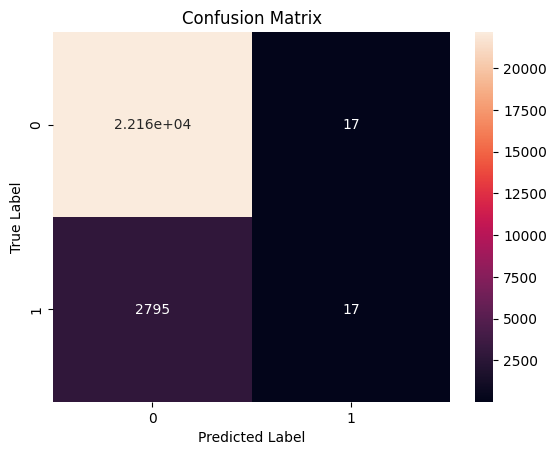

Gradient Boosting Classifier found accuracy: 88.747%, precision: 50.0%, recall: 0.605%


In [129]:
# Best models here are only .886, similar to random forest or logistical regression.  Lets check it on the test data

gb2 = GradientBoostingClassifier(learning_rate=0.1, max_depth=3, n_estimators=50)
gb2.fit(x_train_reduced, y_train_array)

y_pred_gb = gb2.predict(x_test_reduced) # get the predicted y-values
print('In the true data, ' + str(y_test_array.count(1)) + ' were readmitted, while ' + str(y_test_array.count(0)) + ' were not')
print('The model predicted that, ' + str(y_pred_gb.tolist().count(1)) + ' were readmitted, while ' + str(y_pred_gb.tolist().count(0)) + ' were not')

confusionMatrix(y_pred_gb)
describeModelResults('Gradient Boosting Classifier', y_pred_gb)

In [ ]:
# Like the  models before, this is very poor, predicts almost everyone wasn't readmitted within 30 days with very poor recall
# I could tune the threshold, but since this is performing a bit worse than random forest, lets leave it here.

In [ ]:
# Model #4: Multilayer Perceptron Classifier
# print some info about the model
# print(help(MLPClassifier))

In [137]:
# Since this model is supposed to be strongest at finding complex relationships, lets use
# the full dataset with all predictors and see if it can find anything the other models couldn't
#
# use BayesSearchCV to wrap the model, giving it different hyperparameters to try out
# in MLP, will try different hidden layer sizes, activation settings, and learning rate settings
#
# Also setting cv to 3, which means in cross fold validation, the data will be divided into 3 parts, 2 parts 
# to be used as train data, and 1 part for test, then it will rotate to use the other 2 parts as train and the third
# as test. Helps reduce over fitting. 
mlp = BayesSearchCV(
    MLPClassifier(),
    {
        # These models take forever so lets leave hidden layer size at default of (100,)
        # 'hidden_layer_sizes': ((10,), (50,), (100,)),
        'activation': ('relu', 'tanh', 'logistic'),
        'learning_rate': ('constant', 'invscaling', 'adaptive')
    },
    n_iter=32,
    cv=3
)

# fit the model to the data
np.int = int # some error related to skopt using np.int but np.int is deprecated in newer versions of numpy
start = time.time()
mlp.fit(x_train, y_train_array)
end = time.time()
print('These MLP models took about ', round((end - start) / 60, 2), 'minutes to run')

# Note: convergence warnings mean the the model isn't finished improving itself at the default
# max_iter=200, so could increase this, but training will take ever longer

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) 

These MLP models took about  31.75 minutes to run


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [141]:
print(mlp.best_params_)

OrderedDict([('activation', 'relu'), ('learning_rate', 'constant')])


In [139]:
# Check results of all hyperparameter combos that BayesSearchCV checked
means = mlp.cv_results_['mean_test_score']
stds = mlp.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, mlp.cv_results_['params']):
	print('{} (+/-{}) for {}'.format(round(mean, 3), round(std * 2, 3), params))

0.885 (+/-0.0) for OrderedDict([('activation', 'relu'), ('learning_rate', 'constant')])
0.886 (+/-0.0) for OrderedDict([('activation', 'relu'), ('learning_rate', 'constant')])
0.885 (+/-0.002) for OrderedDict([('activation', 'relu'), ('learning_rate', 'invscaling')])
0.886 (+/-0.0) for OrderedDict([('activation', 'relu'), ('learning_rate', 'constant')])
0.884 (+/-0.001) for OrderedDict([('activation', 'logistic'), ('learning_rate', 'constant')])
0.885 (+/-0.002) for OrderedDict([('activation', 'relu'), ('learning_rate', 'constant')])
0.884 (+/-0.001) for OrderedDict([('activation', 'tanh'), ('learning_rate', 'adaptive')])
0.884 (+/-0.002) for OrderedDict([('activation', 'logistic'), ('learning_rate', 'adaptive')])
0.884 (+/-0.0) for OrderedDict([('activation', 'tanh'), ('learning_rate', 'constant')])
0.885 (+/-0.0) for OrderedDict([('activation', 'relu'), ('learning_rate', 'adaptive')])
0.884 (+/-0.001) for OrderedDict([('activation', 'logistic'), ('learning_rate', 'invscaling')])
0.88

In the true data, 2812 were readmitted, while 22177 were not
The model predicted that, 73 were readmitted, while 24916 were not


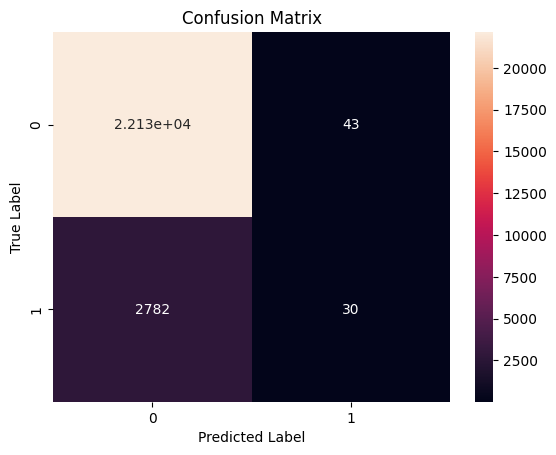

Multilayer Perceptron found accuracy: 88.695%, precision: 41.096%, recall: 1.067%


In [143]:
# Will use best hyperparameters found above, although the results aren't any better than
# previous models. Will also increase max_iter, so that hopefully this model will converge
mlp2 = MLPClassifier(activation='relu', learning_rate='constant', max_iter=500)
mlp2.fit(x_train_reduced, y_train_array)

y_pred_mlp = mlp2.predict(x_test_reduced) # get the predicted y-values
print('In the true data, ' + str(y_test_array.count(1)) + ' were readmitted, while ' + str(y_test_array.count(0)) + ' were not')
print('The model predicted that, ' + str(y_pred_mlp.tolist().count(1)) + ' were readmitted, while ' + str(y_pred_mlp.tolist().count(0)) + ' were not')

confusionMatrix(y_pred_mlp)
describeModelResults('Multilayer Perceptron', y_pred_mlp)

In [ ]:
# Results of best MLP model are dismally similar to other models, with 88.6% accuracy
# and favoring placing the vast majority of people in the majority group.  I could change
# probabilities here to improve recall as I did with random forest, but the cost to
# precision will be high

In [ ]:
# Model #5: K-Nearest Neighbors Classifier
# print some info about the model
# print(help(KNeighborsClassifier))

In [146]:
# use BayesSearchCV to wrap the model, giving it different hyperparameters to try out
# in KNeighbors, will try different neighbors, weights, and leaf size
#
# Also setting cv to 3, which means in cross fold validation, the data will be divided into 3 parts, 2 parts 
# to be used as train data, and 1 part for test, then it will rotate to use the other 2 parts as train and the third
# as test. Helps reduce over fitting. 
kn = BayesSearchCV(
    KNeighborsClassifier(),
    {
        'n_neighbors': (3, 5, 7),
        'weights': ('uniform', 'distance'),
        # 'algorithm': ('auto', 'ball_tree', 'kd_tree', 'brute') # for sake of time, lets leave auto so it decides
        'leaf_size': (10, 30, 50)
    },
    n_iter=32,
    cv=3
)

# fit the model to the data
np.int = int # some error related to skopt using np.int but np.int is deprecated in newer versions of numpy
start = time.time()
kn.fit(x_train, y_train_array)
end = time.time()
print('These K-nearest neighbors models took about ', round((end - start) / 60, 2), 'minutes to run')



/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-pac

These K-nearest neighbors models took about  2.9 minutes to run


In [147]:
print(kn.best_params_)

OrderedDict([('leaf_size', 50), ('n_neighbors', 7), ('weights', 'uniform')])


In [148]:
# Check results of all hyperparameter combos that BayesSearchCV checked
means = kn.cv_results_['mean_test_score']
stds = kn.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, kn.cv_results_['params']):
	print('{} (+/-{}) for {}'.format(round(mean, 3), round(std * 2, 3), params))

0.883 (+/-0.001) for OrderedDict([('leaf_size', 50), ('n_neighbors', 7), ('weights', 'uniform')])
0.883 (+/-0.001) for OrderedDict([('leaf_size', 30), ('n_neighbors', 7), ('weights', 'uniform')])
0.878 (+/-0.001) for OrderedDict([('leaf_size', 50), ('n_neighbors', 5), ('weights', 'uniform')])
0.883 (+/-0.001) for OrderedDict([('leaf_size', 50), ('n_neighbors', 7), ('weights', 'distance')])
0.878 (+/-0.001) for OrderedDict([('leaf_size', 30), ('n_neighbors', 5), ('weights', 'distance')])
0.878 (+/-0.001) for OrderedDict([('leaf_size', 30), ('n_neighbors', 5), ('weights', 'distance')])
0.862 (+/-0.002) for OrderedDict([('leaf_size', 30), ('n_neighbors', 3), ('weights', 'distance')])
0.878 (+/-0.001) for OrderedDict([('leaf_size', 30), ('n_neighbors', 5), ('weights', 'uniform')])
0.883 (+/-0.001) for OrderedDict([('leaf_size', 10), ('n_neighbors', 7), ('weights', 'distance')])
0.878 (+/-0.001) for OrderedDict([('leaf_size', 10), ('n_neighbors', 5), ('weights', 'uniform')])
0.878 (+/-0.001

In [149]:
kn2 = KNeighborsClassifier(leaf_size=50, n_neighbors=7, weights='uniform')
kn2.fit(x_train, y_train_array)

KNeighborsClassifier(leaf_size=50, n_neighbors=7)

In the true data, 2812 were readmitted, while 22177 were not
The model predicted that, 191 were readmitted, while 24798 were not


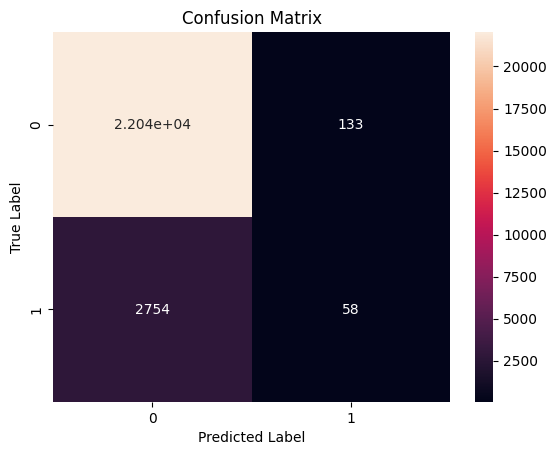

KNeighborsClassifier found accuracy: 88.447%, precision: 30.366%, recall: 2.063%


In [152]:
y_pred_kn = kn2.predict(x_test) # get the predicted y-values
print('In the true data, ' + str(y_test_array.count(1)) + ' were readmitted, while ' + str(y_test_array.count(0)) + ' were not')
print('The model predicted that, ' + str(y_pred_kn.tolist().count(1)) + ' were readmitted, while ' + str(y_pred_kn.tolist().count(0)) + ' were not')

confusionMatrix(y_pred_kn)
describeModelResults('KNeighborsClassifier', y_pred_kn)

In [ ]:
# Model                         accuracy   precision    recall
# Logistic Regression           88.731%    47.619%      1.422%
# Random Forest Classifier      88.783%    66.667%      0.64%
# Gradient Boosting Classifier  88.747%    50.0%        0.605%
# Multilayer Perceptron         88.695%    41.096%      1.067%
# K-Neighbors Classifier        88.447%    30.366%      2.063%
#
# RandomForestClassifier details:
#    Best hyperparameters combo I found: ('max_depth', 20), ('n_estimators', 100)])
#    To better favor precision, explored different thresholds. For instance:
#    At threshold: 0.07, predicted readmitted: 19882, predicted not readmitted: 19558, accuracy: 29.737%, precision: 12.916%, recall: 91.323%
#    At threshold: 0.05, predicted readmitted: 24129, predicted not readmitted: 19558, accuracy: 14.414%, precision: 11.509%, recall: 98.755%
# Gradient Boosting Classifier details:
#    Best hyperparameters combo I found: ('learning_rate', 0.1), ('max_depth', 3), ('n_estimators', 50)
# Logistic Regression Details:
#    Best model had default hyperparameters
#    3 strongest predictors were 
#    - discharge disposition, 
#    - number of inpatient visits in past year
#    - change in diabetes med 
# Multilayer Perceptron details:
#    Best hyperparameters combo I found: ('activation', 'relu'), ('learning_rate', 'constant')
# KNeighborsClassifier details:
#    Best hyperparameters combo I found: ('leaf_size', 50), ('n_neighbors', 7), ('weights', 'uniform')
# 

In [ ]:
# Lessons learned
#
# Although these rates are all pretty similar, Random Forest Classifier stands out as the strongest
# followed by Gradient Boosting Classifier.
#
# All models struggled to differentiate pts destined to be readmitted in 30 days from those who weren't based on predictors available.
# Including predictors not found to have a linear relationship with the outcome (but could have some other complex relationships)
# did not help in models where both datasets were tried.
#
# When tuned by default to prioritize accuracy, the highest accuracy rate of 88.8% is little better than a prediction that 0 
# patients would be re-hospitalized in 30 days, which would be correct 88.7% of the time
#
# When the best model was tuned to prioritize precision, we'd have to assume that just over half of all patients are at risk of 
# being re-hosp in order to capture almost all of the 11% who will be re-hosp. 
#
# Next steps
#
# To move forward, I'd return to the data and try the following:
# - Standardize/center continuous predictors, and transform those whose distributions are skewed
# - Re-look at some predictors removed, such as comorbid diagnoses with someone with medical expertise
# - Re-look at categorical variables, consider bringing back some diversity in categories that I'd originally merged and consider
#   re-coding to be roughly ordinal wherever theoretically possible (e.g., admission status of emergency, urgent, elective, trauma 
#   could be coded as ordinal)
# - Consider strategies to make the outcome categories more balanced which might help some algorithms
# - Try SVM, although it's not usually recommended for tall data with tons of rows and not that many predictors

In [153]:
# pickle the best model and save to a file
joblib.dump(rf3, './RandomForestClassifier.pkl')

['../RandomForestClassifier.pkl']